## Library Project  
#### Presented at [BiLT Europe 2019](https://www.dbeinstitute.org/event/bilt-europe-2019/) in Edinburgh by [Thomas Corrie](http://www.thomascorrie.com/)

***

<img src='../Images/LibraryProjectBanner.png' />

***

# Notebook 1: Run Packing

### Description
This Notebook parses json for the bookcase scenario and runs a series of packing jobs

<span style="color:red">*Comments in red are notes for future improvements and refinements</span>

# Imports

In [1]:
import pandas as pd # For dataframes and manipulation
import numpy as np # For arrays and numbers
import json # For parsing json files
import random # For generating random numbers
import time # For sleep
import glob # For files
import shutil # For copying files
import os # For files
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting
import subprocess # For opening Revit
# iPyWidgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout #ipywidgets
import ipywidgets as widgets 
# Report Python Version
from platform import python_version
print(python_version())

3.6.8


Optional to suppress warnings from Seaborn / Matplotlib for large plots

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Scenario and Paths
The location of the scenario and results json files

In [3]:
bookcaseScenarios = '../Json/2_BookcaseScenarios/'

In [4]:
pathJob = '../Json/3_PackingJob/'

In [5]:
pathResults = '../Json/4_PackingResults/'

In [6]:
visualizationJob = '../Json/5_VisualizationJob/'

In [7]:
revitFiles = '../Revit/Scenarios/'

In [8]:
revitLocation = r'C:\Program Files\Autodesk\Revit 2019\Revit.exe'

In [33]:
bookcaseScenarioFiles = []
for file in glob.glob(bookcaseScenarios + "*.json"):
    bookcaseScenarioFiles.append(os.path.splitext(os.path.basename(file))[0])
chooseDrop = widgets.Dropdown(
    options=list(bookcaseScenarioFiles),
    description='Scenario: ',
    disabled=False,
    layout={'width': 'initial'}
)
chooseItems = [chooseDrop]
widgets.Box(chooseItems)

Box(children=(Dropdown(description='Scenario: ', layout=Layout(width='initial'), options=('191004T230422_Seven…

The variable names for **shelf types**

In [10]:
shelfEmpty = 'Shelf-Empty'
shelfFixed = 'Shelf-Fixed'
shelfFlexible = 'Shelf-Flexible'

# PackingVariables
Set options for the packing job

Number of **iterations** to run

In [11]:
iterations = 1

Which **container strategy** to use:
* 0 Greedy
* 1 Groups
* 2 Minimum-Sized Groups

In [12]:
containerStrategies = [2]

**thresholds** determines how likely a flexible shelf is to be placed or not. A higher threshold means that fewer flexible shelves are likely to be placed whereas a lower threshold make more flexible shelves likely

In [13]:
thresholds = [0.8] # [0.75,0.8,0.85,0.9] #[0.1,0.25,0.5,0.75,0.9]

**minimumItems** sets the minimum number of items that the Packing Algorithm will consider per container when packing continuously

In [14]:
minimumItems = [40] #[25,30,35,40,45,50,55,60]

**maxCantilevers** sets the maximum cantilever allowed for a book in mm

In [15]:
maxCantilevers = [0] # [0,5,10,15,20]

**containerOrientation** determines EB_AFIT rotation:
* 0  All Scenarios
* 1  L x H x W
* 2  W x H x L
* 3  W x L x H
* 4  H x L x W
* 5  L x W x H
* 6  H x W x L

In [16]:
containerOrientations = [0]

**infillVolumePriority** sets whether vertical or horizontal infill volumes are prioritized:

* 0 Max Volume
* 1 Vertical
* 2 Horizontal
* 3 Vertical Only
* 4 Horizontal Only

In [17]:
infillVolumePriorities = [0]

**infillMaxHeight** sets the maximum height allowed for the horizontal infill above placed items

In [18]:
infillMaxHeights = [150]

**bookAlignment** sets the alignment of the books relative to the front of the shelf:
* 0 Front
* 1 Back
* 2 Front with Maximum Cantilever
* 3 Align Back with the Deepest Book

In [19]:
bookAlignments = [0] # [0,2]

**scoringWeights** sets the weights for the following scoring methods
* 0 itemOrientation
* 1 itemPosition
* 2 itemPriority
* 3 itemGrouping

In [70]:
scoringWeights = [0,0,1,0]

# Container Priority
Each bookcase is divided vertically into the specified number of divisions which can be one of a specified number of priorirites where 0 is the highest

In [50]:
numPriorityDivision = 4
numPriorities = 5

In [51]:
bookcaseScenario = chooseDrop.value + '.json'
# Get Number of Bookcases
with open(bookcaseScenarios + bookcaseScenario, encoding='utf-8-sig') as json_file:
        json_data = json.load(json_file)
        numBookcases = len(json_data['bookcases'])
idBookcase = sorted(list(json_data['bookcases'].keys()))
# Generate DropDowns for priority
priorityParams = np.linspace(0,1,numPriorityDivision+1).tolist()
ddBookcase = []
for i in range(numBookcases):
    ddBookcase.append([])
    ddBookcase[-1].append(widgets.Label(str(idBookcase[i])))
    for j in range(numPriorityDivision):
        w = widgets.Dropdown(
            options=[str(x) for x in range(numPriorities)],
            value='0',
            layout={'width': 'initial'},
            description='', # str(i),
            disabled=False,
        )
        ddBookcase[-1].append(w)
boxes = []
for i in range(numBookcases):
    box = widgets.VBox(ddBookcase[i])
    boxes.append(box)
widgets.HBox(boxes)

<span style="color:red">Better integrate dropdowns and heatmap so that a change to a dropdown triggers an immediate update</span>

Create a dictionary of priorites for each shelf

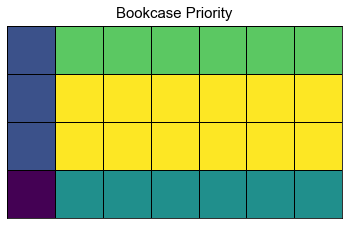

In [52]:
priorityValues = [[float(x.value) for x in sublist[1:]] for sublist in ddBookcase] # Crop labels
transpose = [list(i) for i in zip(*priorityValues)] # Transpose lists
priority = {}
extent=[0,len(transpose[0]),len(transpose),0]
for id, pv in zip(idBookcase,priorityValues):
    priority[id] = list(reversed(pv))
plt.imshow(transpose, cmap='viridis_r', interpolation='nearest',extent=extent)
extent = (0, len(transpose[0]), len(transpose), 0)
ax = plt.gca()
ax.set_yticks(np.arange(0, len(transpose), 1));
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
ax.tick_params(top=False, bottom=False, left=False, labeltop=False, labelbottom=False, labelleft=False)
plt.title(label='Bookcase Priority', fontdict={'name': 'Arial','fontsize': '15','fontweight' : 'light','verticalalignment': 'bottom'})
plt.show()

# Run Packing
Iterate through shelves and randomize flexible shelves. Run a packing job for each configuration by calling Dynamo CLI

<span style="color:red">Using ! prefix to call CLI doesn't allow for variables as path so switch to subprocess to call DynamoCLI?</span>

In [71]:
shelfDatas = []
results = []
scenario = []
# Create Stop file to stop the process if it is deleted
f = open(pathJob + 'Stop.txt','w+')
f.close()
# Loop over iterations
for i in range(iterations):
    # Check for Stop file
    if not glob.glob(pathJob + 'Stop.txt'):
        print('Fail')
        break
    # Process
    shelfData = {}
    # Select Random values from parameter lists
    threshold = random.choice(thresholds) # Choose random threshold from list
    minimumItem = random.choice(minimumItems) # Choose random minimumItem from List
    maxCantilever = random.choice(maxCantilevers) # Choose random maxCantilever from List
    containerStrategy = random.choice(containerStrategies) # Choose random containerStrategy from List
    containerOrientation = random.choice(containerOrientations) # Choose random containrOrientation from List
    infillVolumePriority = random.choice(infillVolumePriorities) # Choose random infillVolumePriority from List
    bookAlignment = random.choice(bookAlignments) # Choose random bookAlignment from List
    infillMaxHeight = random.choice(infillMaxHeights) # Choose random infillMaxHeight from List
    with open(bookcaseScenarios + bookcaseScenario, encoding='utf-8-sig') as json_file:
        json_data = json.load(json_file)
        countFlexible, countFixed, countEmpty, countFlexibleTrue, countFlexibleFalse, countAllTrue, countAll = 0, 0, 0, 0, 0, 0, 0
        # Loop through bookcases and shelves within scenario
        for key in json_data['bookcases']:
            json_data['bookcases'][key]['priority'] = priority[key]
            for k in json_data['bookcases'][key]['shelves']:
                countAll = countAll + 1
                shelfType = json_data['bookcases'][key]['shelves'][k]['shelfType']
                if shelfType != shelfFlexible: # Fixed shelf
                    b = True
                    countAllTrue = countAllTrue + 1
                    if shelfType == shelfEmpty:
                        countEmpty = countEmpty + 1
                    elif shelfType == shelfFixed:
                        countFixed = countFixed + 1
                else: # Flexible shelf
                    r = random.random()
                    if r > threshold:
                        b = True
                        countFlexibleTrue = countFlexibleTrue + 1
                        countAllTrue = countAllTrue + 1
                    else:
                        b = False
                        countFlexibleFalse = countFlexibleFalse + 1
                    countFlexible = countFlexible + 1
                json_data['bookcases'][key]['shelves'][k]['use'] = b
        if countFlexibleTrue == 0:
            percentFlexibleTrue = 0
        else:
            percentFlexibleTrue = round(countFlexibleTrue / countFlexible * 100, 1)
        shelfData.update([ 
            ('shelvesFixed', countFixed), ('shelvesEmpty', countEmpty), ('shelvesFlexible', countFlexible),
            ('shelvesFlexibleTrue', countFlexibleTrue), ('shelvesFlexibleFalse', countFlexibleFalse),
            ('shelvesTrue', countAllTrue), ('shelvesAll', countAll), ('shelvesThreshold', threshold),
            ('shelvesPercentFlexible', percentFlexibleTrue), 
            ('minimumItems', minimumItem), ('maxCantilever', maxCantilever), ('containerStrategy', containerStrategy),
            ('containerOrientation', containerOrientation), ('infillVolumePriority', infillVolumePriority), 
            ('bookAlignment', bookAlignment), ('infillMaxHeight', infillMaxHeight), ('scoringWeights', scoringWeights)
        ])
        json_data['variables'] = shelfData
    shelfDatas.append(shelfData)
    with open(pathJob + 'job.json', 'w', encoding='utf-8-sig') as json_wfile:
        json.dump(json_data, json_wfile)
    #continue
    time.sleep(1) # Sleep to ensure json is ready before launching DynamoCLI
    ### ------------------------------------- THE PATHS ARE HARDCODED --------------------------------------- ### 
    !"C:\Users\Thomas.corrie\Documents\Dynamo Sandbox\DynamoCoreRuntime2.4.0/DynamoCLI.exe" -o "C:\Users\Thomas.corrie\Box Sync\Library\libraryproject\Dynamo\FurtherLibrary_2_ImportAndPack.dyn"
    time.sleep(1) # Sleep to ensure json is ready before getting with glob
    list_of_files = glob.glob(pathResults + '*')
    latest_file = max(list_of_files, key=os.path.getctime)
    latest_file
    with open(latest_file, encoding='utf-8-sig') as json_file:
        json_data = json.load(json_file)
        results.append(json_data['result'])
        scenario.append(json_data['scenario'])
    

loaded file


# Analysis
Show information about packing job

In [72]:
len(shelfDatas)

1

Turn results into a dataframe and drop selected columns

In [73]:
dfShelfData = pd.DataFrame(shelfDatas)
dfResults = pd.DataFrame(results)
dfMerge = dfShelfData.merge(dfResults, left_index = True, right_index = True)
dfResultsReduced = dfMerge.drop(['numBooksTotal','shelvesEmpty','shelvesFixed',
                                   'shelvesFlexible','shelvesFlexibleFalse',
                                   'shelvesPercentFlexible','shelvesAll','shelvesTrue',
                                   'platform','scenarioName','username','packName','computer',
                                 'containerOrientation', 'containerStrategy', 'infillMaxHeight', 'bookAlignment',
                                 'infillVolumePriority','numDiscrepancy'
                                  ], axis=1)
dfResultsReduced['shelvesThreshold'] = dfResultsReduced['shelvesThreshold'].apply(lambda x: "T: "+str(x))
dfResultsReduced.head()

,maxCantilever,minimumItems,scoringWeights,shelvesFlexibleTrue,shelvesThreshold,datetime,description,dynamoFilename,dynamoLong,dynamoShort,meanScore,meanScorePlaced,numBooksNotPacked,numBooksPacked,numContainers,timePack
0,0,40,"[0, 0, 1, 0]",0,T: 0.8,191008T181410,Seven Shelves as Now,FurtherLibrary_2_ImportAndPack,2.4.0.6186,2.4.0,0.415258,0.427653,24,804,31,1.101


In [74]:
dfScenarioData = pd.DataFrame(scenario)
dfScenarioData

,combinations,computer,datetime,description,dynamoFilename,dynamoLong,dynamoShort,numBookcases,platform,revitFilename,scenarioName,username
0,1.0,HA-L1918,2019-10-06T11:32:10.3140902+01:00,Seven Shelves as Now,FurtherLibrary_1_CreateBookcaseScenario,2.0.3.8810,2.0.3,7,Revit,FurtherShelves_SevenAsNow,191006T113210_SevenShelvesasNow,thomas.corrie


Show Scatter Plot of Results

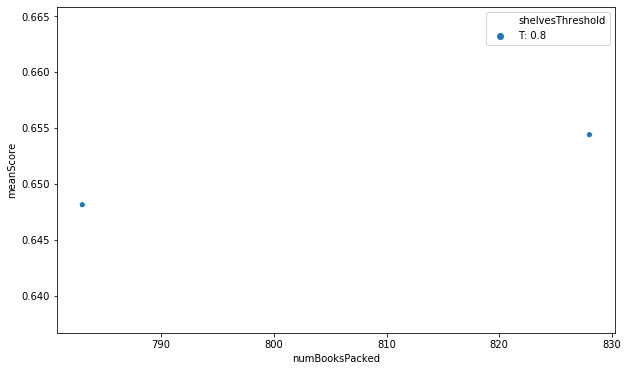

In [85]:
scatter = plt.figure(figsize=(10, 6))
sns.scatterplot(x='numBooksPacked', y='meanScore', hue='shelvesThreshold', data=dfResultsReduced);
# scatter.savefig("../Resources/Graphs/ScatterJoined.png")

Heatmap of correlation selected numeric variables

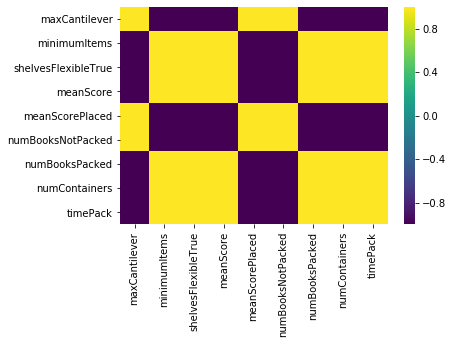

In [88]:
sns.heatmap(dfResultsReduced.select_dtypes(['number']).corr(), cmap='viridis'); #Plot the correlation as heat map

Pairplot between selected numeric variables

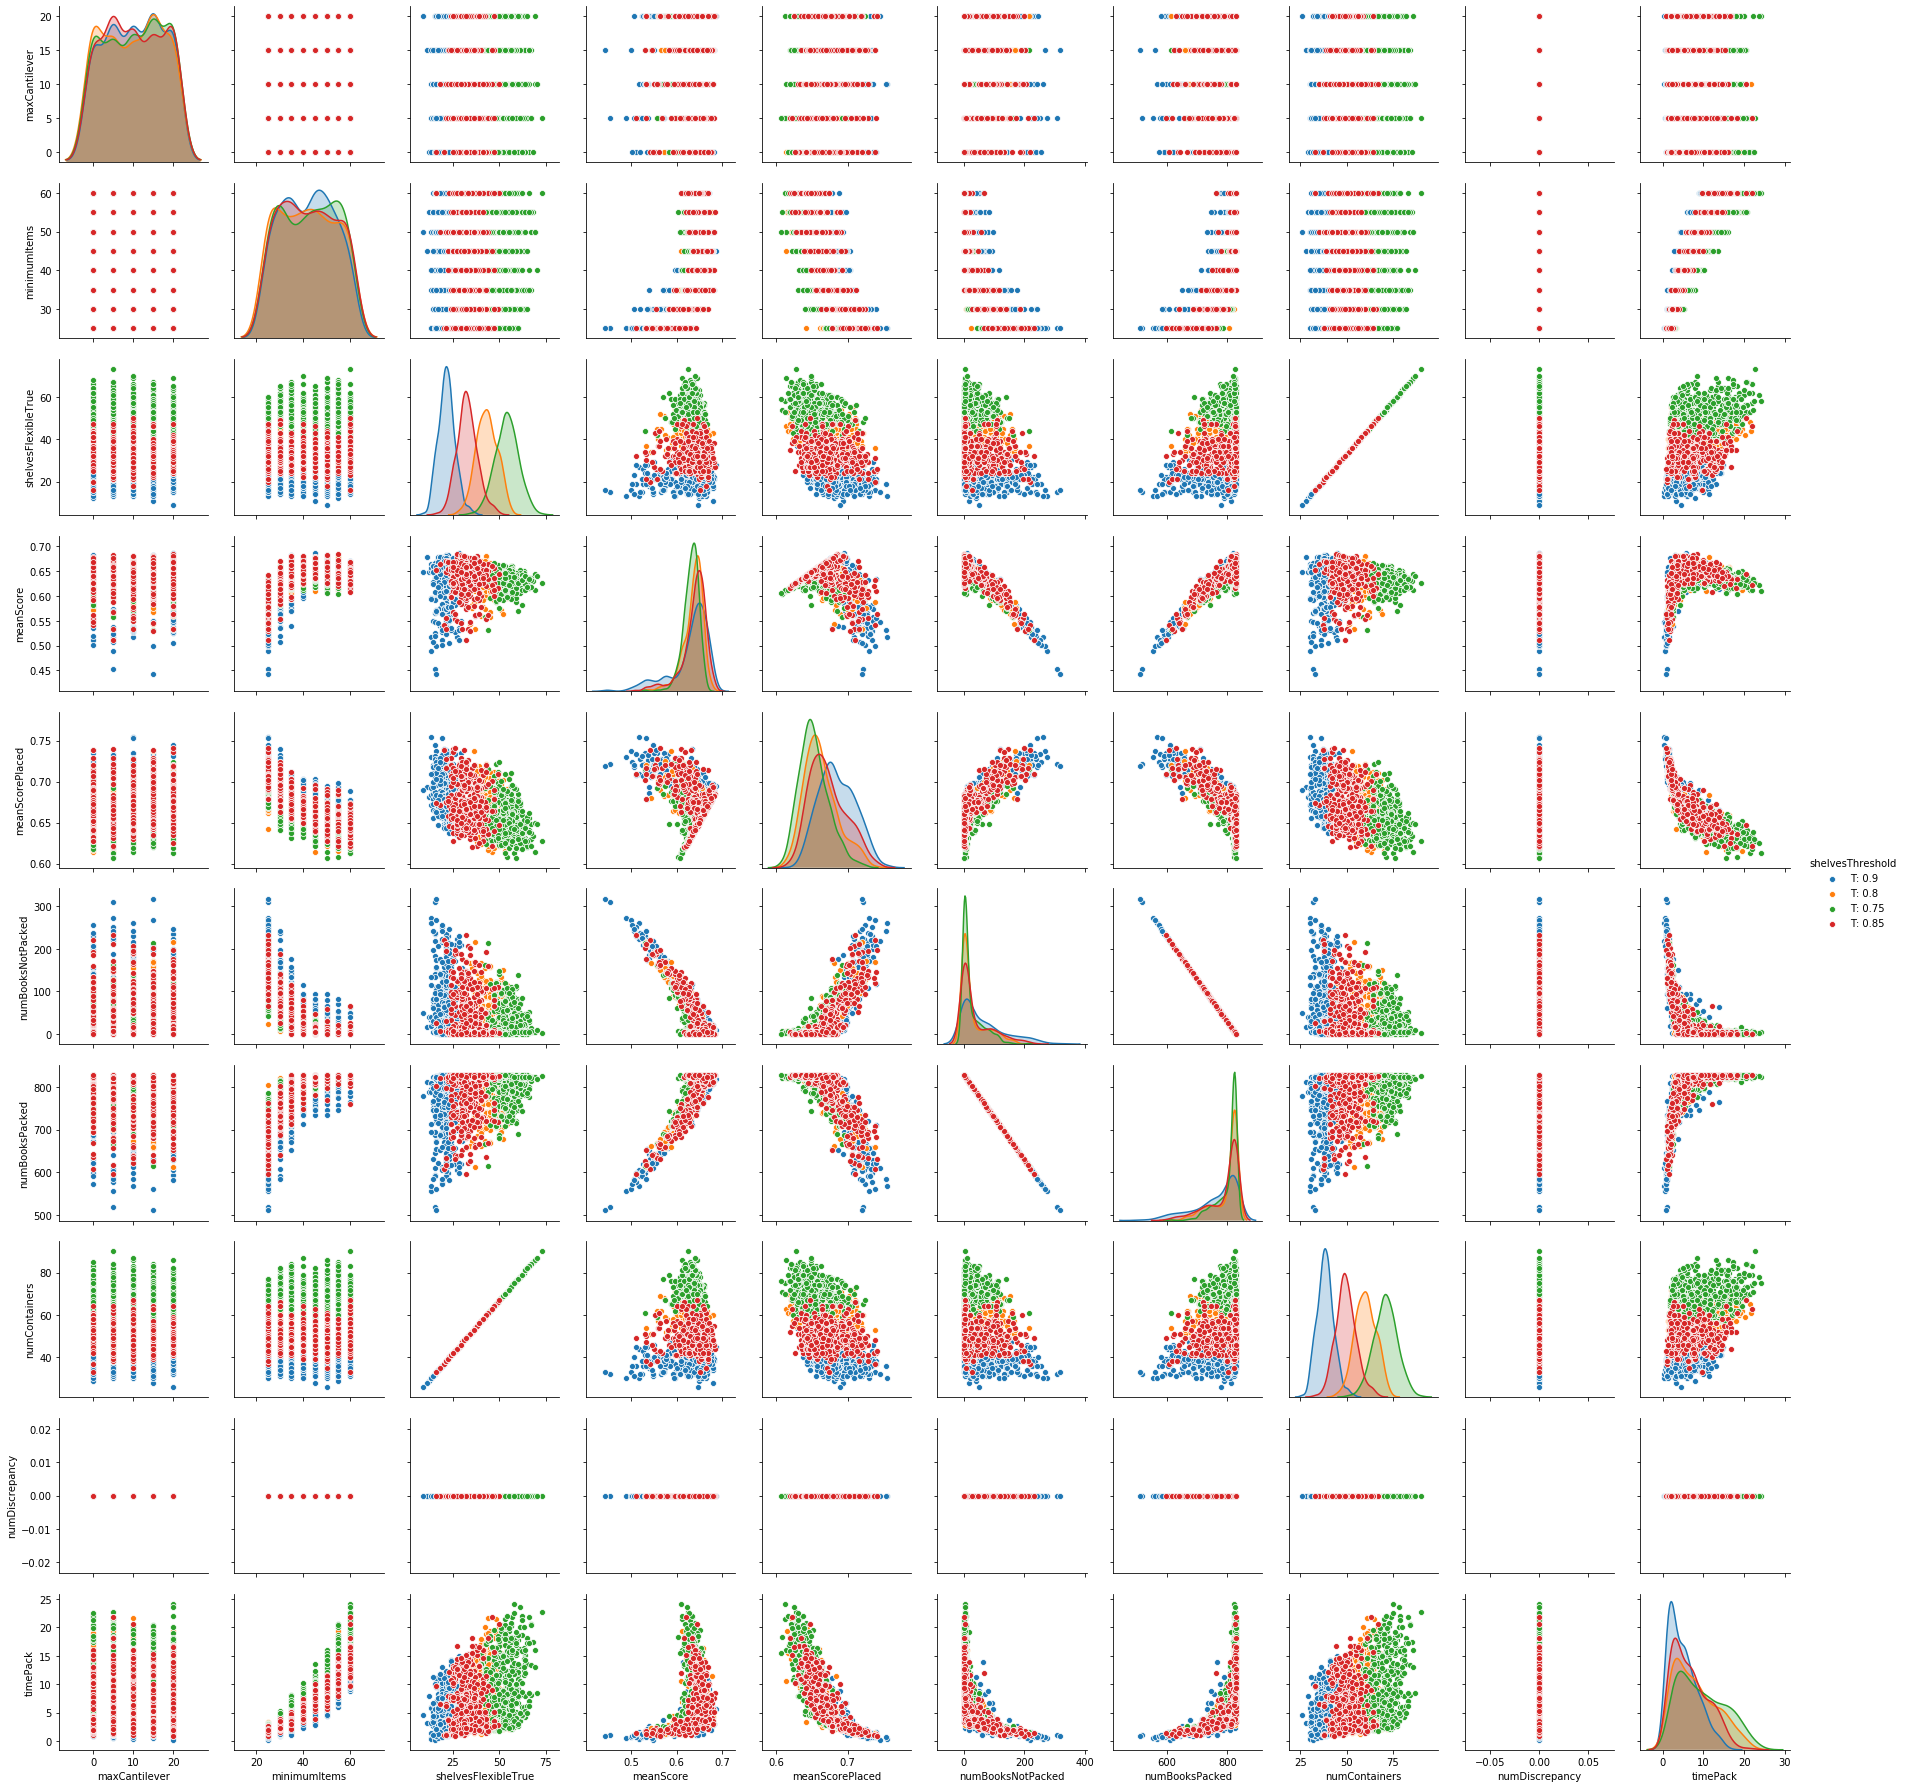

In [29]:
pairplot = sns.pairplot(dfResultsReduced, hue='shelvesThreshold') # kind='reg'
pairplot.savefig("../Resources/Graphs/OutputJoined.png")

# Prepare for Visualizing in Revit
Select Index of Result to Visualize

In [75]:
indexNum = 0

In [76]:
dfResults.iloc[indexNum]
dfScenarioData.iloc[indexNum]

combinations                                            1
computer                                         HA-L1918
datetime                2019-10-06T11:32:10.3140902+01:00
description                          Seven Shelves as Now
dynamoFilename    FurtherLibrary_1_CreateBookcaseScenario
dynamoLong                                     2.0.3.8810
dynamoShort                                         2.0.3
numBookcases                                            7
platform                                            Revit
revitFilename                   FurtherShelves_SevenAsNow
scenarioName              191006T113210_SevenShelvesasNow
username                                    thomas.corrie
Name: 0, dtype: object

Copy results json and Revit scenario to visualization job folder

In [77]:
packName = dfResults.iloc[indexNum]['packName']
fileToCopy = glob.glob(pathResults + packName + '.json')[0]
fileToWrite = visualizationJob + 'visualizationJob.json'
fileToCopyRevit = revitFiles + dfScenarioData.iloc[indexNum]['revitFilename'] + '.rvt'
fileToWriteRevit = visualizationJob + 'scenarioRevit.rvt'
shutil.copyfile(fileToCopy,fileToWrite);
shutil.copyfile(fileToCopyRevit,fileToWriteRevit);

Open Revit with underlying rvt scenario file using subprocess

In [78]:
fileToOpen = fileToWriteRevit
# Use subprocess.Popen rather than subprocess.run as run waits for a return from the program
subprocess.Popen([revitLocation, fileToOpen]);